In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

from src import SpotifyService
from src.utils import split_into_batches
from src.data_process import preprocess_data
from src.data_analysis import plot_feature_dists, calc_correlation, plot_correlation, get_top_abs_correlations
from src.constants import feature_cols

/var/folders/hr/gjtj1mgn7rsfrmbctbb46f6c0000gq/T/ipykernel_12520/3331525809.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Choose artist to perform analysis on
artist = 'JPEGMAFIA' # my favourite artist

## Retrieving Spotify data via API

In [3]:
# Instantiate Spotify service by retrieving access token
service = SpotifyService()

In [4]:
# get all tracks from artist
tracks_s = service.get_songs_from_artist_name(artist)

In [5]:
print(f"Number of tracks by {artist}:", len(tracks_s))

Number of tracks by JPEGMAFIA: 225


In [6]:
# Get audio features of each track (split into batches before sending HTTP requests)
chunks = split_into_batches(tracks_s.values)
audio_feats_df = service.get_audio_feats_full(chunks)

In [7]:
# Get popularity of each track
audio_feats_df['popularity'] = audio_feats_df['id'].apply(service.get_popularity_from_track_id)

In [8]:
audio_feats_df.head(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,popularity
0,0.411,0.765,11,-4.993,0,0.326,0.122,0.0,0.341,0.747,139.801,audio_features,3rEV55xgPvHCegchp8qTUD,spotify:track:3rEV55xgPvHCegchp8qTUD,https://api.spotify.com/v1/tracks/3rEV55xgPvHC...,https://api.spotify.com/v1/audio-analysis/3rEV...,305783,3,46
1,0.443,0.914,2,-4.535,1,0.888,0.498,0.0,0.360,0.608,85.016,audio_features,4BFteJu5Hv7XStDXghJbQ7,spotify:track:4BFteJu5Hv7XStDXghJbQ7,https://api.spotify.com/v1/tracks/4BFteJu5Hv7X...,https://api.spotify.com/v1/audio-analysis/4BFt...,265053,4,51
2,0.553,0.509,1,-7.955,1,0.353,0.515,0.0,0.154,0.264,153.674,audio_features,5r7OKhOQl2vM8SZnCXSQk1,spotify:track:5r7OKhOQl2vM8SZnCXSQk1,https://api.spotify.com/v1/tracks/5r7OKhOQl2vM...,https://api.spotify.com/v1/audio-analysis/5r7O...,210570,4,53


In [9]:
# Optional: download requested data locally to avoid resending requests to API
os.makedirs("./data", exist_ok=True)
audio_feats_df.to_csv(f"./data/{artist.lower().replace(' ', '-')}.csv", index=False)

In [10]:
try:
    df = pd.read_csv(f"./data/{artist.lower().replace(' ', '-')}.csv")
    print(f'Retrieving data for {artist} stored locally already...')
except FileNotFoundError:
    try:
        df = audio_feats_df.copy()
    except NameError as ne:
        print(ne)
        print(f'Retrieve data on {artist} from Web API first.')

Retrieving data for JPEGMAFIA stored locally already...


## Data Analysis + Data Viz

In [11]:
# Preprocessing: drop nulls and convert duration from ms to mins
data = preprocess_data(df)
data

,id,popularity,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins
0,3rEV55xgPvHCegchp8qTUD,46,0.411,0.765,-4.993,0,0.3260,0.1220,0.000000,0.3410,0.747,139.801,5.096383
1,4BFteJu5Hv7XStDXghJbQ7,51,0.443,0.914,-4.535,1,0.8880,0.4980,0.000000,0.3600,0.608,85.016,4.417550
2,5r7OKhOQl2vM8SZnCXSQk1,53,0.553,0.509,-7.955,1,0.3530,0.5150,0.000000,0.1540,0.264,153.674,3.509500
3,7fA0kOF3D0hlkZCkHifxOC,24,0.592,0.572,-6.636,1,0.1840,0.4880,0.000006,0.1590,0.250,119.819,3.341700
4,5iy1CCubJb2vyKxDASUqA7,40,0.832,0.694,-4.199,1,0.5930,0.0769,0.000000,0.3910,0.849,146.328,2.072217
...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,3DEBzHTerlbxX71CutsAoR,30,0.753,0.704,-5.926,1,0.0611,0.1480,0.004680,0.3750,0.725,93.640,2.261033
221,1y0WuFjKIxlvwCpuHRd3IH,24,0.693,0.852,-5.203,1,0.2750,0.1680,0.000000,0.1330,0.181,94.055,3.957700
222,4yCKWYI9yseYm1Mx7AaLYh,35,0.572,0.636,-5.592,0,0.2170,0.1410,0.000000,0.1300,0.106,132.020,3.071483
223,6xuWcjCHI7zeLgaWjFkE3f,5,0.863,0.717,-3.143,0,0.1700,0.2780,0.082600,0.0991,0.358,152.040,2.620983


In [12]:
# check data types
data.dtypes

id                   object
popularity            int64
danceability        float64
energy              float64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_mins       float64
dtype: object

In [13]:
# basic stats on numerical columns
data.describe()

,popularity,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,33.684444,0.626467,0.762049,-4.903222,0.697778,0.252187,0.246973,0.067824,0.351469,0.440884,121.160191,3.050758
std,15.654842,0.150472,0.149294,2.833968,0.460245,0.160528,0.223732,0.202913,0.226874,0.225915,21.380148,1.042939
min,0.000000,0.213000,0.287000,-16.090000,0.000000,0.031800,0.000610,0.000000,0.054900,0.038600,57.257000,0.731067
25%,21.000000,0.524000,0.667000,-6.150000,0.000000,0.117000,0.072200,0.000000,0.151000,0.253000,107.644000,2.393817
50%,38.000000,0.618000,0.771000,-5.100000,1.000000,0.238000,0.174000,0.000002,0.310000,0.407000,121.575000,2.911667
75%,44.000000,0.723000,0.887000,-3.427000,1.000000,0.349000,0.363000,0.000929,0.463000,0.644000,134.648000,3.615217
max,64.000000,0.949000,0.996000,2.383000,1.000000,0.888000,0.930000,0.986000,0.957000,0.888000,183.985000,6.747350


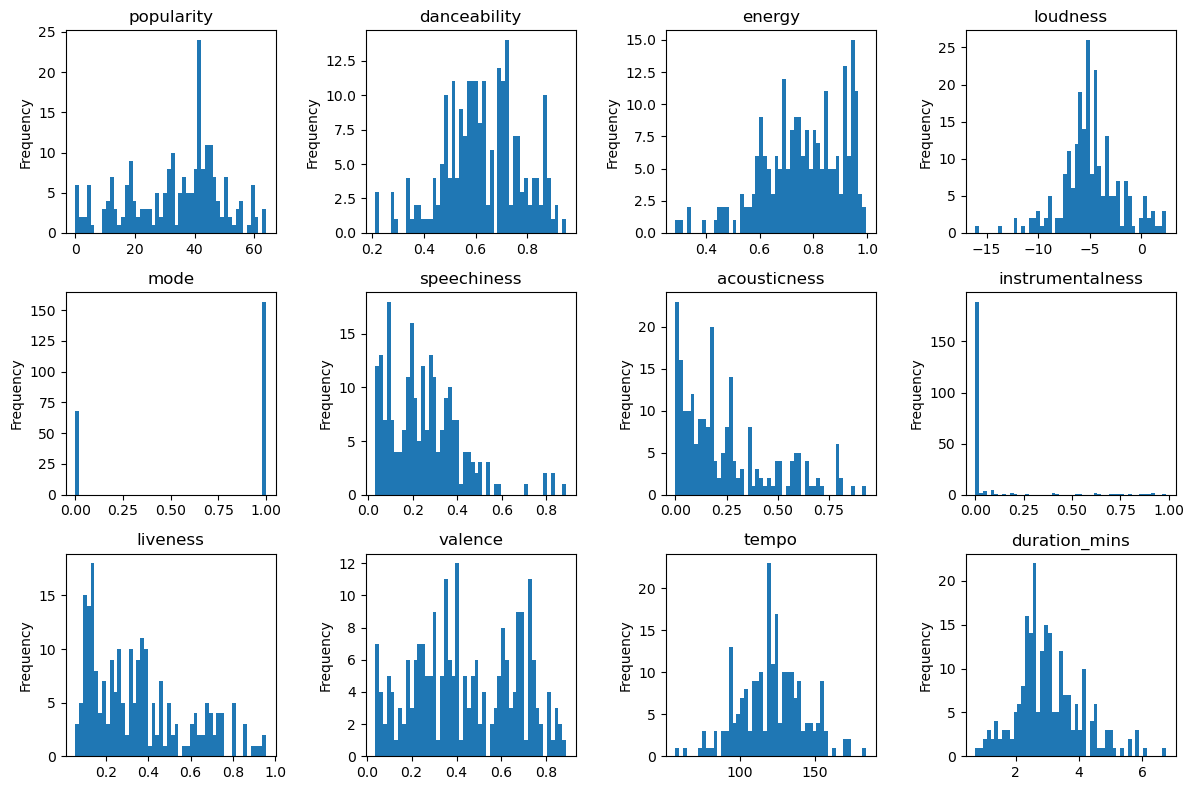

In [14]:
# plot distributions of each numerical feature as part of EDA
plot_feature_dists(data, feature_cols)
plt.show()

In [15]:
# calculate basic correlation matrix on numerical features
corr = calc_correlation(data, feature_cols)
corr

,popularity,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins
popularity,1.000000,-0.194262,0.281552,0.398101,-0.046754,0.118271,-0.047411,-0.353527,-0.049621,0.331557,0.175755,-0.256624
danceability,-0.194262,1.000000,-0.121167,-0.027317,-0.094713,-0.183907,-0.074633,0.038678,0.105724,0.140054,0.002968,0.003156
energy,0.281552,-0.121167,1.000000,0.786741,0.133732,0.353116,-0.346535,-0.253481,0.150903,0.478489,0.235511,-0.222813
loudness,0.398101,-0.027317,0.786741,1.000000,0.022309,0.167417,-0.301436,-0.321369,0.115070,0.539979,0.268116,-0.304744
mode,-0.046754,-0.094713,0.133732,0.022309,1.000000,0.064563,-0.087606,0.037501,0.043673,-0.083347,-0.172900,0.066811
speechiness,0.118271,-0.183907,0.353116,0.167417,0.064563,1.000000,0.004029,-0.236524,0.032291,0.196169,0.158403,0.136335
acousticness,-0.047411,-0.074633,-0.346535,-0.301436,-0.087606,0.004029,1.000000,-0.092100,0.044773,-0.067250,-0.133828,0.151174
instrumentalness,-0.353527,0.038678,-0.253481,-0.321369,0.037501,-0.236524,-0.092100,1.000000,0.033164,-0.283278,-0.056787,0.115662
liveness,-0.049621,0.105724,0.150903,0.115070,0.043673,0.032291,0.044773,0.033164,1.000000,0.182060,-0.076989,0.158150
valence,0.331557,0.140054,0.478489,0.539979,-0.083347,0.196169,-0.067250,-0.283278,0.182060,1.000000,0.136001,-0.348636


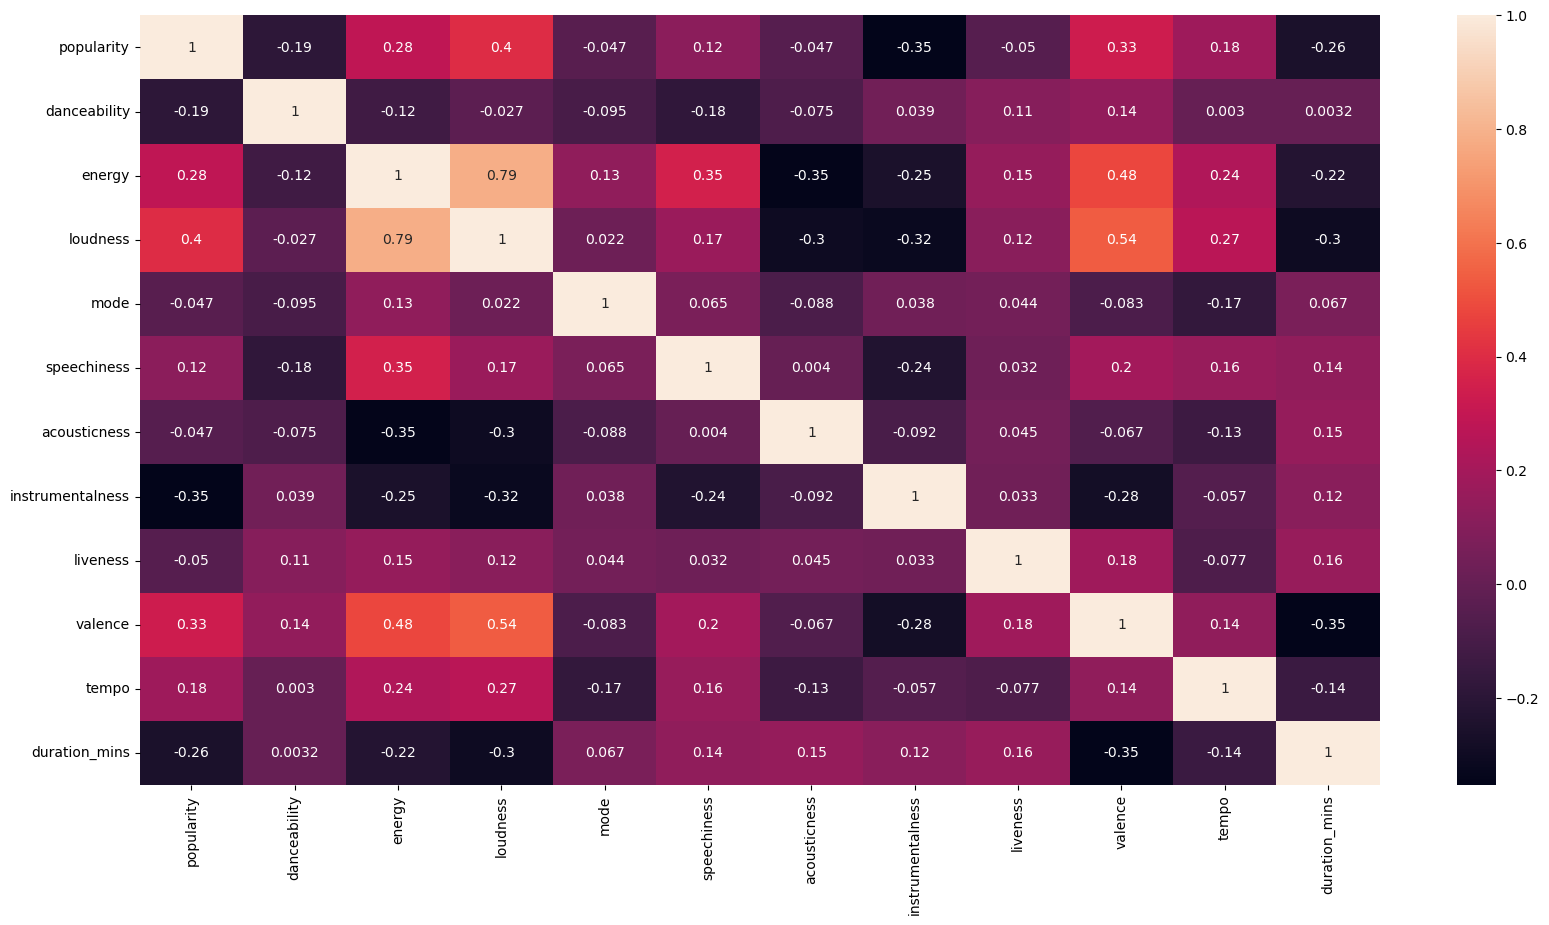

In [16]:
# Visualise strength of correlations by plotting as heatmap
plot_correlation(corr)
plt.show()

In [17]:
top_N_correlations = 5

print("Top Absolute Correlations\n")
print(get_top_abs_correlations(data, feature_cols, top_N_correlations))

Top Absolute Correlations

energy__loudness                0.786741
loudness__valence               0.539979
energy__valence                 0.478489
popularity__loudness            0.398101
popularity__instrumentalness    0.353527
dtype: float64


## Possible next step
Regression model to predict popularity of a song based on audio features